In [1]:
import torch
import os

print(torch.__version__)
print(torch.version.cuda)


2.5.1+cu118
11.8


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from pathlib import Path
data_dir = Path("C:/Users/Raphael/Dev/data_science/libras")

train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

train_dir, test_dir

(WindowsPath('C:/Users/Raphael/Dev/data_science/libras/train'),
 WindowsPath('C:/Users/Raphael/Dev/data_science/libras/test'))

In [4]:
from torchvision.transforms import v2
import random
from PIL import Image

image_path_list = list(data_dir.glob('*/*/*.png'))

random_image_path = random.choice(image_path_list)

img = Image.open(random_image_path)

transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
])


transformed_image = transforms(img).permute(1, 2, 0)
transformed_image.shape

torch.Size([224, 224, 3])

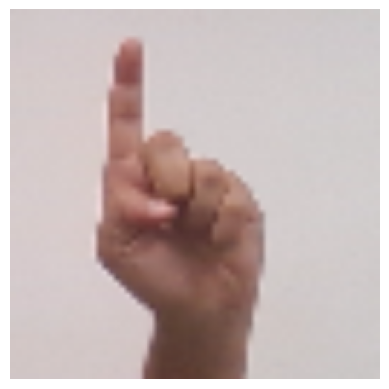

In [5]:
import matplotlib.pyplot as plt

plt.imshow(transformed_image)
plt.axis('off')
plt.show()

Irei usar o ImageFolder para carregar o dataset para o formato suportado pelo PyTorch. Também irei passar o meu `transforms` para já realizar as conversões de todas imagens para tensores.

DOC: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [6]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transforms,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transforms,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 34714
     Root location: C:\Users\Raphael\Dev\data_science\libras\train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToDtype(scale=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 11548
     Root location: C:\Users\Raphael\Dev\data_science\libras\test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToDtype(scale=True)
            ))

Como o meu dataset está no formato:
dataset

|  train
|  |  A
|  |  | xxx.png
|  |  | xxy.png
|  |  | ...
|  |  B
|  |  | xxx.png
|  |  | xxy.png
|  |  | ...
|  test
|  |  A
|  |  | xxx.png
...

Não é necessário utilizar `target_transforms`, as classes serão inferidas a partir dos nomes das pastas em que as imagens se encontram.

In [7]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'I',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'Y'],
 {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'I': 7,
  'L': 8,
  'M': 9,
  'N': 10,
  'O': 11,
  'P': 12,
  'Q': 13,
  'R': 14,
  'S': 15,
  'T': 16,
  'U': 17,
  'V': 18,
  'W': 19,
  'Y': 20})

Agora eu crio `dataloaders` do meu dataset, o que me permite dividir minhas imagens em batches.

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count())
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f57abe32c0>,
 <torch.utils.data.dataloader.DataLoader at 0x1f57c39cda0>)

In [9]:
len(train_dataloader), len(test_dataloader)

(1085, 361)

In [10]:
import torchvision.models as models

efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
efficientnet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
for param in efficientnet.parameters():
    param.requires_grad = True

O código abaixo altera a camada final da arquitetura EfficientNet, passando a classificar a quantidade de classes do meu dataset.

In [12]:
from torch import nn

num_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_features, len(class_names))

efficientnet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Definindo o otimizador e a loss function:

In [24]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.NAdam(efficientnet.parameters(),
                        lr=0.002)
loss_function = nn.CrossEntropyLoss()

efficientnet.to(device)

def accuracy():
    #escrever depois
    accuracy = 0

Enfim partimos para o treinamento do modelo. Como o modelo atual é pré-treinado e já possui pessos específicos, quando treinar ele novamente estarei fazendo uma técnica chamada de Transferência de Aprendizado(Transfer Learning).

In [14]:
from tqdm.auto import tqdm

EPOCHS = 10
epoch_count = []
train_loss_log = []
test_loss_log = []

for epoch in tqdm(range(EPOCHS)):
    print(f'Epoch: {epoch+1}\n-----')
    train_loss = 0
    efficientnet.train()
    for batch, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        labels_preds = efficientnet(images)
        loss = loss_function(labels_preds, labels)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch) % 100 == 0:
            print(f'Progresso: {batch*len(images)}/{len(train_dataloader.dataset)}')

    train_loss /= len(train_dataloader)

    test_loss = 0
    efficientnet.eval()
    with torch.inference_mode():
        for batch, (images, labels) in enumerate(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            test_predictions = efficientnet(images)
            test_loss += loss_function(test_predictions, labels)

        test_loss /= len(test_dataloader)

    epoch_count.append(epoch+1)
    train_loss_log.append(train_loss)
    test_loss_log.append(test_loss)
    print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}\n")

C:\Users\Raphael\Dev\ws-pycharm\data-science\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 10%|█         | 1/10 [03:27<31:08, 207.59s/it]

Train loss: 0.0846 | Test loss: 0.6664

Epoch: 2
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 20%|██        | 2/10 [06:59<28:00, 210.00s/it]

Train loss: 0.0264 | Test loss: 0.0072

Epoch: 3
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 30%|███       | 3/10 [10:39<25:02, 214.60s/it]

Train loss: 0.0188 | Test loss: 0.0053

Epoch: 4
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 40%|████      | 4/10 [14:06<21:10, 211.81s/it]

Train loss: 0.0116 | Test loss: 0.0037

Epoch: 5
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 50%|█████     | 5/10 [17:35<17:33, 210.66s/it]

Train loss: 0.0152 | Test loss: 0.0765

Epoch: 6
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 60%|██████    | 6/10 [21:04<13:59, 209.96s/it]

Train loss: 0.0097 | Test loss: 0.1093

Epoch: 7
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 70%|███████   | 7/10 [24:28<10:24, 208.22s/it]

Train loss: 0.0092 | Test loss: 0.0026

Epoch: 8
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 80%|████████  | 8/10 [28:03<07:00, 210.30s/it]

Train loss: 0.0001 | Test loss: 0.0018

Epoch: 9
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


 90%|█████████ | 9/10 [31:37<03:31, 211.40s/it]

Train loss: 0.0000 | Test loss: 0.0028

Epoch: 10
-----
Progresso: 0/34714
Progresso: 3200/34714
Progresso: 6400/34714
Progresso: 9600/34714
Progresso: 12800/34714
Progresso: 16000/34714
Progresso: 19200/34714
Progresso: 22400/34714
Progresso: 25600/34714
Progresso: 28800/34714
Progresso: 32000/34714


100%|██████████| 10/10 [35:09<00:00, 210.92s/it]

Train loss: 0.0000 | Test loss: 0.0070



In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(train_loss_log, test_loss_log, epoch_count):
  plt.plot(epoch_count, train_loss_log, label="Train Loss")
  plt.plot(epoch_count, test_loss_log, label="Test Loss")
  plt.title("Loss curves")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()

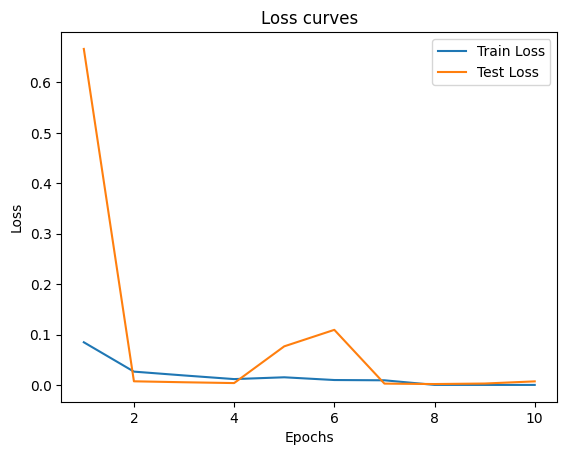

In [19]:
 plot_loss_curves(np.array(torch.tensor(train_loss_log).numpy()), np.array(torch.tensor(test_loss_log).numpy()), epoch_count)

In [20]:
import random

for i in range(15):
    random_image_path = random.choice(image_path_list)
    random_image = Image.open(random_image_path)

    string = str(random_image_path)
    cls = string.split('\\')[7]
    cls = class_dict.get(cls)

    transformed_img = transforms(random_image)

    with torch.inference_mode():
        pred = efficientnet(transformed_img.to(device).unsqueeze(0))

    print(f"Predicted: {pred.argmax()} | Expected: {cls}")


Predicted: 8 | Expected: 8
Predicted: 4 | Expected: 4
Predicted: 20 | Expected: 20
Predicted: 17 | Expected: 17
Predicted: 19 | Expected: 19
Predicted: 1 | Expected: 1
Predicted: 19 | Expected: 19
Predicted: 16 | Expected: 16
Predicted: 0 | Expected: 0
Predicted: 10 | Expected: 10
Predicted: 19 | Expected: 19
Predicted: 9 | Expected: 9
Predicted: 1 | Expected: 1
Predicted: 10 | Expected: 10
Predicted: 5 | Expected: 5
